# Imports

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer 
import json
import seaborn as sns
import re
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer


# Import all we need from nltk
import nltk
import string
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\casey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\casey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\casey\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\casey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Load Data

In [7]:
# https://github.com/PawanKrGunjan/Natural-Language-Processing/blob/main/Sarcasm%20Detection/sarcasm.json 
df = pd.read_json(R"C:\Users\casey\OneDrive\Documents\Data_Science\pandas_exercises\data\sarcasm.json") 
df.head()

article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0

# EDA

* Look for relvant columns
* Explore columns for missing values, values that don't make sense

Get rows and columns

In [8]:
print('There are ', df.shape[0], ' rows.')
print('There are ', df.shape[1], ' columns.')
print('Column Names: ', df.columns)
print('Column Types: ', df.dtypes)

There are  26709  rows.
There are  3  columns.
Column Names:  Index(['article_link', 'headline', 'is_sarcastic'], dtype='object')
Column Types:  article_link    object
headline        object
is_sarcastic     int64
dtype: object


Check for any missing values in relevant columns

In [9]:
## CHECK FOR MISSING VALUES
df.info() # there are no missing values in the Sentiment or OriginalTweet columns which is what we care about

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


## Normalization

In [17]:
# Normalize First

## CONVERT TO LOWERCASE
def to_lowercase(text):
    text = text.lower()
    return text

#df['review'] = df['review'].apply(to_lowercase)

# ------------------------------------------------------------------------------------------------ #
## REMOVE NUMBERS
def remove_numbers(text):
    text = re.sub(r'\d+', '', text)
    return text

#df['review'] = df['review'].apply(remove_numbers)

# ------------------------------------------------------------------------------------------------ #
## REMOVE PUNCTUATION
def remove_punctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))

#df['review'] = df['review'].apply(remove_punctuations)

# ------------------------------------------------------------------------------------------------ #
## REMOVE SPECIAL CHARACTERS
def remove_special_chars(text):
    return re.sub('[^a-zA-Z]', ' ', text)

#df['review'] = df['review'].apply(remove_special_chars)

# ------------------------------------------------------------------------------------------------ #
## REMOVE UNNECESSARY WHITE SPACE
def remove_whitespace(text):
    return  " ".join(text.split())

#df['review'] = df['review'].apply(remove_whitespace)

# ------------------------------------------------------------------------------------------------ #
## REMOVE STOPWORDS

# create list of your own words to also remove
my_stopwords = ['br', 'b']

def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = stopwords.words('english') + my_stopwords
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

#df['review'] = df['review'].apply(remove_stopwords)


# ------------------------------------------------------------------------------------------------ #
## LEMMATIZATION
# usually preferred over stemming
# considers context (word part of speech)
# caring -> care

#lem_df = df.copy()

# Part of speech tagger function
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Instantiate lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_word(text):
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(text))
    #word_tokens = word_tokenize(text)
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))

    lemmatized_review = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_review.append(word)
        else:
            # else use the tag to lemmatize the token
            lemmatized_review.append(lemmatizer.lemmatize(word, tag))
    lemmatized_review = " ".join(lemmatized_review)
    return lemmatized_review

#lem_df['review'] = lem_df['review'].apply(lemmatize_word)

# Twitter Specific Cleaning
def remove_hyperlinks(text):
    return re.sub(r'https?:\/\/.*[\r\n]*', ' ', text)

def remove_hashtag_symbol(text):
    return re.sub(r'#', ' ', text)

def remove_retweet_text(text):
    return re.sub(r'^RT[\s]+', ' ', text)

# ---------------------------------------------------------------------------------------------------------------------------- #
## CUSTOM NORMALIZATION FUNCTION

# choose which preprocessing functions to use
# not using lemmatization or stemming since using a neural network
def custom_normalization(reviews):
    reviews = reviews.apply(to_lowercase)
    reviews = reviews.apply(remove_numbers)
    reviews = reviews.apply(remove_punctuations)
    reviews = reviews.apply(remove_special_chars)
    reviews = reviews.apply(remove_stopwords)
    # reviews = reviews.apply(remove_hyperlinks)
    # reviews = reviews.apply(remove_hashtag_symbol)
    # reviews = reviews.apply(remove_retweet_text)
    reviews = reviews.apply(lemmatize_word)
    return reviews

# df['headline'] = custom_normalization(df['headline'])

Check for texts to omit
* super short
* super long

In [18]:
# sort ascending by tweet length
# may want to omit really short tweets # tweets_df[tweets_df['OriginalTweet'].str.len() > 20]
df['headline'].str.len().sort_values()#[:20]

5322       0
999        0
23711      3
12019      3
22335      3
        ... 
21783    148
17306    164
11220    167
15247    170
19868    227
Name: headline, Length: 26709, dtype: int64

In [20]:
df.loc[5322].headline

''

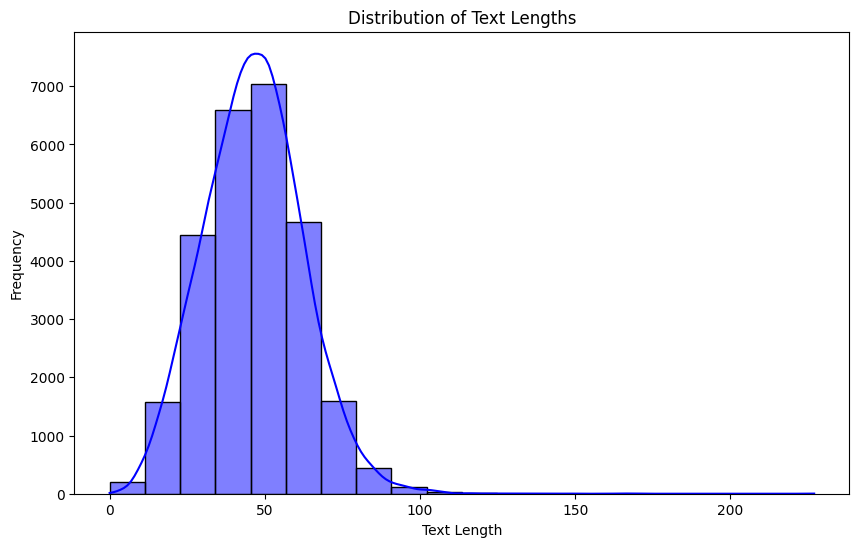

In [21]:
df['headline_length'] = df['headline'].str.len()

# Plot the distribution of text lengths using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(df['headline_length'], bins=20, kde=True, color='blue')  # KDE adds a smooth curve
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Preprocessing

* Need to normalize 
* Need to vectorize text, typically tf-idf
* Use SVD on high-dimensional text data for feature reduction

Select relevant column

In [23]:
# X = df.iloc[:, 2:]
X = df[['headline']]

Determine number of unique words left after normalization

In [27]:
# Ways to determine max_features (words)
# - tune it using optuna, start with like a range of 10% to 30%
# - get the distribution of words eliminate non-contributors

all_words = []
for headline in X.headline:
    for word in headline.split():
        all_words.append(word)
unique_words = set(all_words) # there are about 68000 unique words in the training set
print(len(unique_words))

22518


TF-IDF and SVD (this combo is LSA)
* Try different max_features and n_components

In [58]:
# Step 1: TF-IDF Vectorization
tfidf = TfidfVectorizer(max_df=0.7, min_df=5, stop_words="english", ngram_range=(1,3), max_features=10000)  # You can adjust max_features
tfidf_matrix = tfidf.fit_transform(X['headline'])  # Apply TF-IDF to 'headline'

# Step 2: Apply LSA
lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
X_lsa = lsa.fit_transform(tfidf_matrix)
explained_variance = lsa[0].explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Explained variance of the SVD step: 13.2%


# Choosing K

Three Options
* Elbow Method
* Silhouette Method
* Domain Knowledge

## Elbow Method

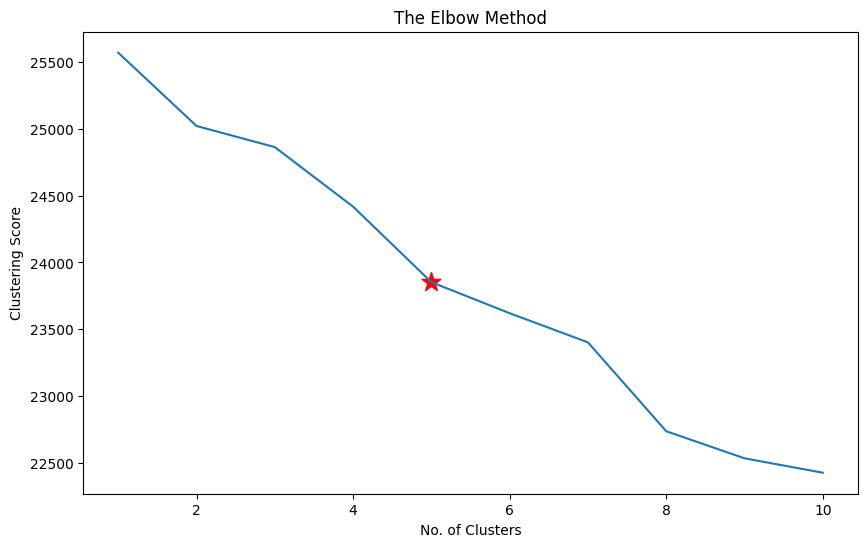

In [59]:
clustering_score = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_lsa)
    clustering_score.append(kmeans.inertia_) # inertia_ = Sum of squared distances of samples to their closest cluster center.
    

plt.figure(figsize=(10,6))
plt.plot(range(1, 11), clustering_score)
plt.scatter(5,clustering_score[4], s = 200, c = 'red', marker='*')
plt.title('The Elbow Method')
plt.xlabel('No. of Clusters')
plt.ylabel('Clustering Score')
plt.show()

## Silhouette Method

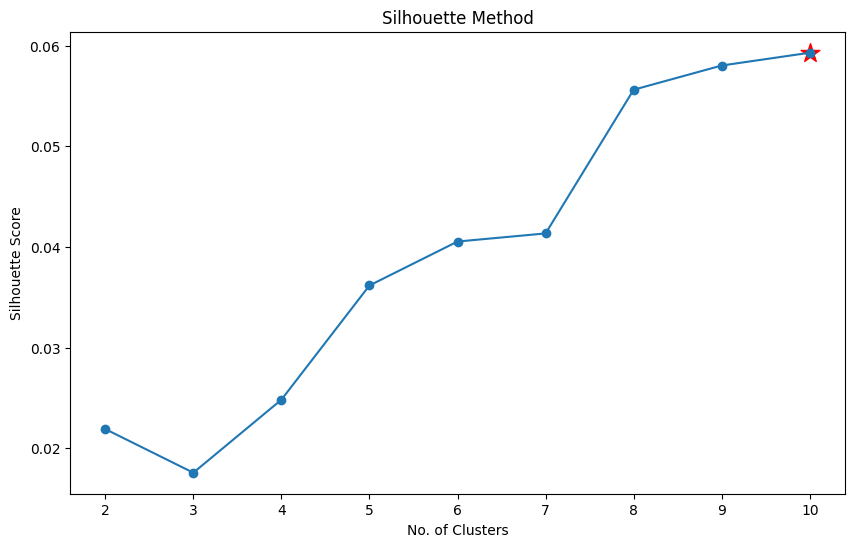

In [60]:
# List to store the silhouette scores for each value of n_clusters
silhouette_scores = []

# Compute silhouette scores for a range of cluster values (starting from 2 since silhouette score doesn't exist for 1 cluster)
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)  # Use k-means++ for better initialization
    kmeans.fit(X_lsa)
    
    # Calculate the silhouette score for the current number of clusters
    score = silhouette_score(X_lsa, kmeans.labels_)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.scatter(2 + silhouette_scores.index(max(silhouette_scores)), max(silhouette_scores), s=200, c='red', marker='*')
plt.title('Silhouette Method')
plt.xlabel('No. of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Modeling

In [61]:
kmeans= KMeans(n_clusters = 10, random_state = 42)

# Compute k-means clustering
kmeans.fit(X_lsa)

# Compute cluster centers and predict cluster index for each sample.
pred = kmeans.predict(X_lsa)

pred

array([1, 5, 4, ..., 1, 7, 5])

Adding the clusters back to the original dataframe

In [62]:
df['Cluster'] = pd.DataFrame(pred, columns=['cluster'] )
print('Number of data points in each cluster= \n', df['Cluster'].value_counts())
df

Number of data points in each cluster= 
 Cluster
1    10775
7     3902
5     3168
8     2157
2     1425
6     1367
9     1276
4     1206
3      748
0      685
Name: count, dtype: int64


article_link  \
0      https://www.huffingtonpost.com/entry/versace-b...   
1      https://www.huffingtonpost.com/entry/roseanne-...   
2      https://local.theonion.com/mom-starting-to-fea...   
3      https://politics.theonion.com/boehner-just-wan...   
4      https://www.huffingtonpost.com/entry/jk-rowlin...   
...                                                  ...   
26704  https://www.huffingtonpost.com/entry/american-...   
26705  https://www.huffingtonpost.com/entry/americas-...   
26706  https://www.huffingtonpost.com/entry/reparatio...   
26707  https://www.huffingtonpost.com/entry/israeli-b...   
26708  https://www.huffingtonpost.com/entry/gourmet-g...   

                                                headline  is_sarcastic  \
0      former versace store clerk sue secret black co...             0   
1      roseanne revival catch thorny political mood w...             0   
2      mom start fear son web series closest thing gr...             1   
3      boehner want wife listen come alternative debt...             1   
4       jk rowling wish snape happy birthday magical way             0   
...                                                  ...           ...   
26704                   american politics moral freefall             0   
26705                                  america best hike             0   
26706                                   reparation obama             0   
26707  israeli ban target boycott supporter raise ala...             0   
26708                                gourmet gift foodie             0   

       headline_length  Cluster  
0                   65        1  
1                   55        5  
2                   54        4  
3                   60        1  
4                   48        1  
...                ...      ...  
26704               32        1  
26705               17        1  
26706               16        1  
26707               55        7  
26708               19        5  

[26709 rows x 5 columns]

Visualize clusters with SVD

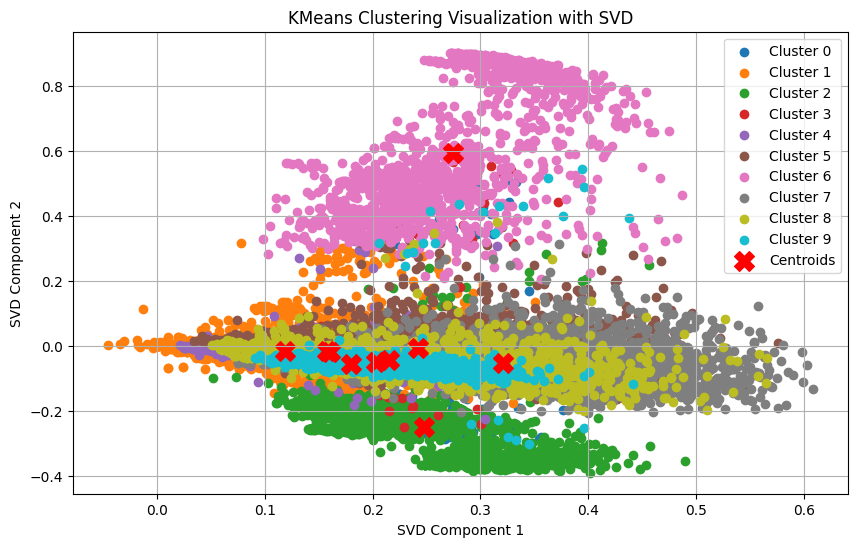

In [64]:
# Reduce dimensions using SVD
svd = TruncatedSVD(n_components=2)
reduced_data = svd.fit_transform(X_lsa)

# Create a DataFrame for the reduced data
reduced_df = pd.DataFrame(reduced_data, columns=['SVD1', 'SVD2'])
reduced_df['Cluster'] = pred

# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster in range(10):
    cluster_data = reduced_df[reduced_df['Cluster'] == cluster]
    plt.scatter(cluster_data['SVD1'], cluster_data['SVD2'], label=f'Cluster {cluster}')

# Plot cluster centers
centers = svd.transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label='Centroids')

plt.title('KMeans Clustering Visualization with SVD')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.legend()
plt.grid()
plt.show()